In [1]:
#load libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

## CIFAR-10 Dataset

In [2]:
from torchvision import datasets,transforms

transform = transforms.ToTensor()
batch_size = 64

dataset = datasets.CIFAR10('data', train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
dataiter = iter(train_loader)
images,labels = dataiter.next()

In [4]:
images.shape

torch.Size([64, 3, 32, 32])

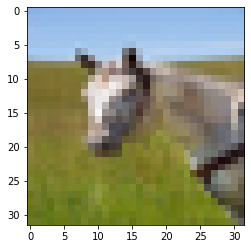

In [5]:
plt.imshow(np.transpose(images[0], (1,2,0)))
plt.show()

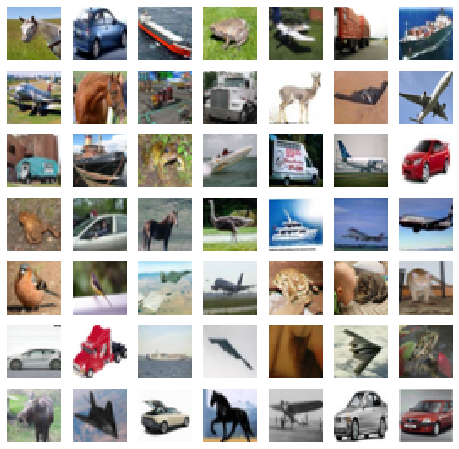

In [6]:
plt.figure(figsize=(8,8))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(images[i],(1,2,0)))
plt.show()

## Define Discriminator

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3,64,3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64,128,4,stride=2, padding=1)
        self.conv3 = nn.Conv2d(128,128,4,stride=2,padding=1)
        self.conv4 = nn.Conv2d(128,256,4,stride=2, padding=1)
        
        self.output = nn.Linear(256*4*4, 1)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self,x):
        
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, 256*4*4)
        out = self.dropout(out)                                 
        
        out = self.output(out)
        
        return out 

## Define Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim = 100):
        super(Generator,self).__init__()
        
        self.fc = nn.Linear(latent_dim, 256*4*4)
        
        self.t_conv1 = nn.ConvTranspose2d(256,128,4, stride=2, padding=1)
        #out = (128,8,8)
        self.t_conv2 = nn.ConvTranspose2d(128,128,4, stride=2, padding=1)
        #out = (128,16,16)
        self.t_conv3 = nn.ConvTranspose2d(128,128,4, stride=2, padding=1)
        #out = (128,32,32)
        self.conv_out = nn.Conv2d(128,3,3, stride=1, padding=1)
        #out = (3,32,32)
        
    def forward(self,x):
        
        out = F.leaky_relu(self.fc(x), 0.2)
        
        out = out.view(-1, 256, 4, 4)
        
        out = F.leaky_relu(self.t_conv1(out))
        out = F.leaky_relu(self.t_conv2(out))
        out = F.leaky_relu(self.t_conv3(out))
        
        out = torch.tanh(self.conv_out(out))             ###  remember to scale input images before training
        
        return out

## Define Losses

In [10]:
def true_loss(d_out):
    batch_size = d_out.size(0)
    
    labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)
    
    return loss
    
def fake_loss(d_out):
    batch_size = d_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)
    
    return loss

## Instantiate Models

In [11]:
train_on_gpu = torch.cuda.is_available()

latent_dim = 100

D = Discriminator()
G = Generator(100)

if train_on_gpu:
    D.cuda()
    G.cuda()
    print('Trainig on GPU \n')
else:
    print('Training in CPU \n')
    
print(G)
print()
print(D)

Training in CPU 

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_out): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (output): Linear(in_features=4096, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


## Define Optimizers

In [12]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5

d_optimizer = optim.Adam(D.parameters(), lr, (beta1, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr, (beta1, 0.999))

## Training Process

In [ ]:
def plot(latent_z, epoch, samples):
    #generate images
    synthetic_images = G(latent_z)
    synthetic_images = (synthetic_images+1)/2
    samples.append(synthetic_images)                #appending for the samples list for later use 
    
    plt.figure(figsize=(8,8,))
    for i in range(49):
        plt.subplot(7,7,i+1)
        plt.axis('off')
        img = synthetic_images[i].cpu().detach()
        img = np.transpose(img, (1,2,0))
        plt.imshow(img)
    
    plt.show()

In [13]:
epochs = 100
show_every = 400

losses = []
samples = []

for e in range(epochs):
    
    for i,(real_images,_) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        
        #rescale training images
        real_images = real_images*2-1 
        
        if train_on_gpu:
            real_images = real_images.cuda()
        
        #####################
        #train discriminator#
        #####################      
        d_optimizer.zero_grad()
        
        # 1.train on real images
        d_r_out = D(real_images)
        d_r_loss = true_loss(d_r_out)
        
        # 2.train on fake images
        latent_z = np.random.randn(batch_size, latent_dim)
        latent_z = torch.from_numpy(latent_z).float()
        if train_on_gpu:
            latent_z = latent_z.cuda()
        
        fake_images = G(latent_z)
        
        d_f_out = D(fake_images)
        d_f_loss = fake_loss(d_f_out)
        
        d_loss = d_r_loss + d_f_loss
        d_loss.backward()
        d_optimizer.step()
        
        #################
        #train generator#
        #################
        g_optimizer.zero_grad()
        
        latent_z = np.random.randn(batch_size, latent_dim)
        latent_z = torch.from_numpy(latent_z).float()
        if train_on_gpu:
            latent_z = latent_z.cuda()
        
        fake_images = G(latent_z)
        
        f_out = D(fake_images)
        g_loss = true_loss(f_out)
        
        g_loss.backward()
        g_optimizer.step()
        
        if i%show_every == 0:
            print(f'Epoch: {e}\t d_loss: {d_loss.item()}\t g_loss: {g_loss.item()}')
            losses.append((g_loss.item(), d_loss.item()))           
            
    if e%5 == 0 :
        plot(fixed_z, e, samples)

In [ ]:
losses = np.array(losses)
plt.plot(losses[:,0], label='g_loss')
plt.plot(losses[:,1]), label='d_loss')
plt.title('Training Losses')
plt.legend()
plt.show()